# **Clustering applied to audio embeddings without dimensionality reduction**

Aplicar métodos de clustering tradicionales a los features extraídos, tanto de VGGish como Librosa (MFCGG, Zero-Crossing Rate, RMSE), sin aplicar reducción de dimensionalidad. Métodos a usar:

- KNN
- Logistic Regression
- SVM
- Decision tree, random forest, XGBoost
- Naive Bayes (hacer test de independencia?)

Métricas de evaluación
- Accuracy
- Precision
- Recall
- F1 score

**Estructura general del notebook:**

    I. VGGish features
    II. Librosa features (1)
    III. Librosa features (2)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

In [2]:
def show_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average="weighted")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted")
    rec = recall_score(y_true, y_pred, average="weighted")

    print("F1 score: ", f1)
    print("Accuracy: ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)

## **I. VGGish features**

### Load features

In [2]:
def load_features_ids_labels(filename:str, has_labels=True):
    """
    Description:
        Cargar los features, ids y labels de un archivo npz.
        Si es data de testeo, has_labels=False
    """

    contents = np.load(filename, allow_pickle=True)
    features = contents['features']
    ids = contents['ids']

    if has_labels:
        labels = contents['labels']
        return features, ids, labels
    
    return features, ids

In [3]:
X, ids, y = load_features_ids_labels(filename='features_npz/features_cremad.npz', has_labels=True)
y = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

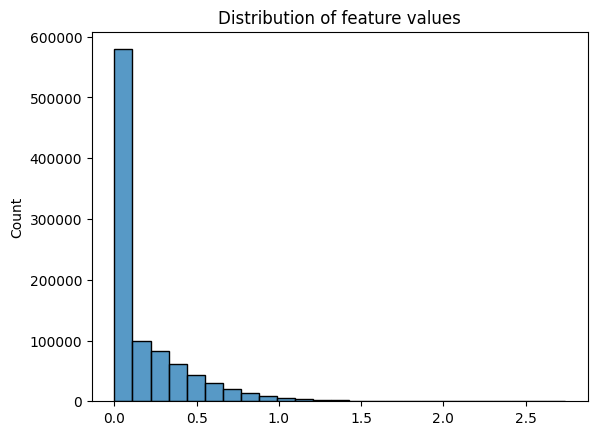

In [4]:
sns.histplot(X.flatten(), bins=25)
plt.title("Distribution of VGGish feature values")
plt.show()

In [7]:
print(X_train.shape)

(5953, 128)


In [4]:
standardScaler = StandardScaler()
X_train_std = standardScaler.fit_transform(X_train)
X_test_std = standardScaler.transform(X_test)

### XGBoost

In [6]:
labels_dict = {}
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    labels_dict[label] = i
y_train_num = np.array([labels_dict[elem] for elem in y_train])
y_test_num = np.array([labels_dict[elem] for elem in y_test])

In [9]:
bst = XGBClassifier(n_estimators=32, max_depth=8, learning_rate=1)
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.44024178107222567
Accuracy:  0.4445936870382807
Precision:  0.4377827270947972
Recall:  0.4445936870382807


### Logistic Regression

In [9]:
lr = LogisticRegression(random_state=0)
lr.fit(X=X_train, y=y_train)
lr_pred = lr.predict(X_test)

show_metrics(y_true=y_test, y_pred=lr_pred)

F1 score:  0.47701952279328347
Accuracy:  0.48354600402955006
Precision:  0.47436348718784804
Recall:  0.48354600402955006


d:\Documents-D\Projects\emotion-recognition-in-speech\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Naive Bayes

In [19]:
gnb = GaussianNB()
gnb.fit(X=X_train, y=y_train)
gnb_pred = gnb.predict(X_test)

show_metrics(y_true=y_test, y_pred=gnb_pred)

F1 score:  0.25884613065768763
Accuracy:  0.30624580255204836
Precision:  0.3638678202852358
Recall:  0.30624580255204836


### SVM
RBF y polinomial de otros grados tienen peores resultados

In [17]:
svm = SVC(random_state=0, kernel='poly', degree=3)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.504275237447437
Accuracy:  0.5124244459368704
Precision:  0.5046910909103162
Recall:  0.5124244459368704


### KNN

In [31]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

show_metrics(y_test, knn_pred)

F1 score:  0.4345002503671903
Accuracy:  0.45601074546675624
Precision:  0.43824110864821403
Recall:  0.45601074546675624


### Decision Tree

In [35]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

show_metrics(y_test, dt_pred)

F1 score:  0.32251627382349335
Accuracy:  0.3237071860308932
Precision:  0.3221188125679233
Recall:  0.3237071860308932


### Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=128, criterion="gini", max_depth=8, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

show_metrics(y_test, rf_pred)

F1 score:  0.4487514356621093
Accuracy:  0.4630010277492292
Precision:  0.5017715103873288
Recall:  0.4630010277492292


## **II. Librosa features (1)**
Los features extraídos con librosa tienen varios nulos. En esta experimentación (1), todos los nulos fueron reemplazados por el valor 0. En la experimentación (2) se aplicaron otros métodos de data cleaning.

### Load features

In [4]:
df_raw = pd.read_csv("D:/Documents-D/Downloads/emotion.csv")
df = df_raw.fillna(0)

In [5]:
X = df.iloc[: ,:-1].values
y = df['Emotions'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((38918, 2376), (38918,), (9730, 2376), (9730,))

### Logistic Regression

In [13]:
lr = LogisticRegression(random_state=0)
lr.fit(X=X_train, y=y_train)
lr_pred = lr.predict(X_test)

show_metrics(y_true=y_test, y_pred=lr_pred)

d:\Documents-D\Projects\emotion-recognition-in-speech\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1 score:  0.44062535831062755
Accuracy:  0.4411099691675231
Precision:  0.44088416096125516
Recall:  0.4411099691675231


### SVM

In [14]:
svm = SVC(random_state=0, kernel='poly', degree=3)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.5869512160773809
Accuracy:  0.587667009249743
Precision:  0.6260423869561978
Recall:  0.587667009249743


### Decision Tree

In [15]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

show_metrics(y_test, dt_pred)

F1 score:  0.4897263371892782
Accuracy:  0.4894141829393628
Precision:  0.49017442484418083
Recall:  0.4894141829393628


### XGBoost

In [7]:
labels_dict = {}
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    labels_dict[label] = i
y_train_num = np.array([labels_dict[elem] for elem in y_train])
y_test_num = np.array([labels_dict[elem] for elem in y_test])

In [12]:
bst = XGBClassifier(n_estimators=32, max_depth=10, learning_rate=1) 
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.7060374309591502
Accuracy:  0.7061664953751284
Precision:  0.7073265402399541
Recall:  0.7061664953751284


## **III. Librosa features (2)**
En esta experimentación (2) se aplicaron más métodos de data cleaning. 

1. Se eliminaron las columnas con más de 20% de valores faltantes. 
2. Los valores faltantes que quedaron fueron imputados con medianas

In [3]:
df_raw = pd.read_csv("D:/Documents-D/Downloads/emotion.csv")
print(df_raw.isna().sum().sum()) # cantidad de nulos original

28245624


In [42]:
columns_without_nans = df_raw.columns[df_raw.isna().sum() == 0]
print( len(columns_without_nans)) # cantidad de COLUMNAS sin nulos

639


In [53]:
# cantidad de FILAS sin nulos
df_raw.dropna().shape[0]

11024

In [4]:
# drop columnas con más de 20% de nulos
columns_to_drop = []
for col in df_raw.columns:
    nans = df_raw[col].isna().sum()
    if nans / df_raw.shape[0] >= 0.2:
        columns_to_drop.append(col)
dfc = df_raw.drop(columns=columns_to_drop)
print("old shape: ", df_raw.shape, ". New shape: ", dfc.shape)

old shape:  (48648, 2377) . New shape:  (48648, 1365)


In [5]:
X = dfc.iloc[: ,:-1]
y = dfc['Emotions']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [6]:
emotions = np.unique(y)
for emotion in emotions:
    bm_train = y_train == emotion
    medians = X_train[bm_train].median(skipna=True)
    medians_general = X_train.median(skipna=True)

    # Llenar con las medianas de cada emoción específica de training
    for col in X_train.columns:
        X_train.loc[bm_train, col] = X_train.loc[bm_train, col].fillna(value=medians[col])

    # se supone que en testing no sabemos los labels de antemano, entonces llenamos con las medianas de todas las emociones
    for col in X_test.columns:
        X_test[col] = X_test[col].fillna(value=medians_general[col])
X_train.isna().sum().sum()

np.int64(0)

In [7]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### KNN

In [11]:
ks = [5, 10, 15, 20, 25, 30, 40, 50, 100]
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)

    print("n neighbors: ", k)
    show_metrics(y_test, knn_pred)
    print()

n neighbors:  5
F1 score:  0.6115954323378916
Accuracy:  0.6113052415210689
Precision:  0.61794806059474
Recall:  0.6113052415210689

n neighbors:  10
F1 score:  0.5535662823149118
Accuracy:  0.5543679342240493
Precision:  0.563344860361172
Recall:  0.5543679342240493

n neighbors:  15
F1 score:  0.5285222705387306
Accuracy:  0.5304213771839671
Precision:  0.5409473702620802
Recall:  0.5304213771839671

n neighbors:  20
F1 score:  0.509628239622197
Accuracy:  0.5118191161356629
Precision:  0.525950828667017
Recall:  0.5118191161356629

n neighbors:  25
F1 score:  0.5001396613583382
Accuracy:  0.5027749229188078
Precision:  0.5179343558509377
Recall:  0.5027749229188078

n neighbors:  30
F1 score:  0.48782671726149945
Accuracy:  0.4916752312435766
Precision:  0.5080715108022507
Recall:  0.4916752312435766

n neighbors:  40
F1 score:  0.4701600315070816
Accuracy:  0.47533401849948614
Precision:  0.4935042029732374
Recall:  0.47533401849948614

n neighbors:  50
F1 score:  0.45336109199263

### Decision Tree

In [12]:
dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

show_metrics(y_test, dt_pred)

F1 score:  0.4197422650856108
Accuracy:  0.41788283658787256
Precision:  0.42944674935365934
Recall:  0.41788283658787256


### Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=64, criterion="gini", max_depth=10, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

show_metrics(y_test, rf_pred)

F1 score:  0.3924927339350771
Accuracy:  0.42559095580678313
Precision:  0.4344098162123649
Recall:  0.42559095580678313


### SVM polinomial de grado 3

In [15]:
svm = SVC(random_state=0, kernel='poly', degree=3)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.49154275022128974
Accuracy:  0.5006166495375128
Precision:  0.5226643586746433
Recall:  0.5006166495375128


### SVM polinomial de grado 4

In [16]:
svm = SVC(random_state=0, kernel='poly', degree=4)
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.49959975568833065
Accuracy:  0.5050359712230216
Precision:  0.5472682236986379
Recall:  0.5050359712230216


### SVM función de base radial

In [17]:
svm = SVC(random_state=0, kernel='rbf')
svm.fit(X=X_train, y=y_train)
svm_pred = svm.predict(X_test)

show_metrics(y_true=y_test, y_pred=svm_pred)

F1 score:  0.49989196217190424
Accuracy:  0.5083247687564234
Precision:  0.5146758442394511
Recall:  0.5083247687564234


### XGBoost

In [45]:
labels_dict = {}
unique_labels = np.unique(y)
for i, label in enumerate(unique_labels):
    labels_dict[label] = i
y_train_num = np.array([labels_dict[elem] for elem in y_train])
y_test_num = np.array([labels_dict[elem] for elem in y_test])

In [101]:
# Habiendo imputado valores en base a la clase (como hacer trampa)
"""
Ejemplo: Sea la fila n una observación de "happy". 
Si a esta fila le falta un valor en la columna c, 
este se llena con la mediana del valor de c de 
aquellas observaciones de "happy" que no son nulas.
"""
bst = XGBClassifier(n_estimators=32, max_depth=10, learning_rate=1) 
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.7476865457120212
Accuracy:  0.7478931140801645
Precision:  0.7493381612811466
Recall:  0.7478931140801645


In [59]:
"""
Habiendo imputado con medianas idependientemente de la clase
"""
bst = XGBClassifier(n_estimators=32, max_depth=10, learning_rate=1) 
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.606634207421125
Accuracy:  0.6118191161356629
Precision:  0.6264285176598383
Recall:  0.6118191161356629


In [52]:
# drop columnas con algún nulo
# columns_to_drop = []
# for col in df_raw.columns:
#     nans = df_raw[col].isna().sum()
#     if nans > 0:
#         columns_to_drop.append(col)
# dfc = df_raw.drop(columns=columns_to_drop)
# print("old shape: ", df_raw.shape, ". New shape: ", dfc.shape)

"""
Habiendo droppeado TODAS las columnas con al menos 1 nulo (quedan aprox 639 columnas)
"""

bst = XGBClassifier(n_estimators=32, max_depth=10, learning_rate=1) 
bst.fit(X_train, y_train_num)
pred_bst = bst.predict(X_test)

pred_bst_ = [unique_labels[i] for i in pred_bst]
show_metrics(y_true=y_test, y_pred=pred_bst_)
show_metrics(y_true=y_test, y_pred=pred_bst_)

F1 score:  0.6943120335051848
Accuracy:  0.6943473792394655
Precision:  0.6955719687471097
Recall:  0.6943473792394655
